# **Imports**

In [1]:
!pip install pydot

In [2]:
import tensorflow as tf
tf.config.run_functions_eagerly(True) # Use eager execution mode, since the call function throws an error otherwise.

from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import time

2024-08-20 19:44:12.455151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 19:44:12.455388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 19:44:12.657801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.callbacks import Callback

In [4]:
import PIL

from IPython.display import display, FileLink

import shutil

In [5]:
from datetime import datetime

# **Configure processor use**
Use TPU, GPU, or CPU, in that order, based on availability.

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.MirroredStrategy()
            print("Running on GPU.")
        else:
            strategy = tf.distribute.get_strategy()
            print("Running on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on CPU.
Number of replicas: 1
2.15.0


# **Load the data**

In [7]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [8]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [9]:
IMAGE_SIZE = [256, 256] # Size according to info on the competition page

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [10]:
# Function to extract the image from the files (?)
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
    return dataset

In [11]:
# # Load the data sets
# monet_ds = load_dataset(MONET_FILENAMES).batch(1)
# photo_ds = load_dataset(PHOTO_FILENAMES).batch(1)

monet_ds = load_dataset(MONET_FILENAMES)
photo_ds = load_dataset(PHOTO_FILENAMES)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [12]:
%%time 

# Check the number of batches in each data set
monet_batch_count = 0
for _ in monet_ds:
    monet_batch_count += 1

print(f"Number of batches in monet_ds: {monet_batch_count}")

photo_batch_count = 0
for _ in photo_ds:
    photo_batch_count += 1

print(f"Number of batches in photo_ds: {photo_batch_count}")

Number of batches in monet_ds: 300
Number of batches in photo_ds: 7038
CPU times: user 15.2 s, sys: 2.44 s, total: 17.7 s
Wall time: 53.3 s


# **Split the data inte training and validation sets**

In [46]:
# Set ratio to use for validation
val_ratio = 0.98
train_ratio = 1 - val_ratio

# Calculate number of batches for training and validation
train_size_monet = int(train_ratio * monet_batch_count)  
val_size_monet = monet_batch_count - train_size_monet

train_size_photo = int(train_ratio * photo_batch_count)  
val_size_photo = photo_batch_count - train_size_photo

# Split the datasets
train_monet_ds = monet_ds.take(train_size_monet)
val_monet_ds = monet_ds.skip(train_size_monet).take(val_size_monet)

train_photo_ds = photo_ds.take(train_size_photo)
val_photo_ds = photo_ds.skip(train_size_photo).take(val_size_photo)

# Shuffle the training sets
train_monet_ds = train_monet_ds.shuffle(buffer_size = train_size_monet)
train_photo_ds = train_photo_ds.shuffle(buffer_size = train_size_photo)

In [47]:
# Batch the datasets after splitting
# train_monet_ds = train_monet_ds.batch(1).repeat()
# val_monet_ds = val_monet_ds.batch(1).repeat()

# train_photo_ds = train_photo_ds.batch(1).repeat()
# val_photo_ds = val_photo_ds.batch(1).repeat()

# **Exploratory Data Analysis**

In [48]:
# pick a monet picture and a photo from the data sets
example_monet = next(iter(val_monet_ds))
example_photo = next(iter(val_photo_ds))

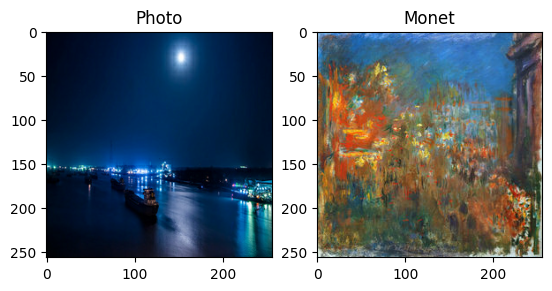

In [49]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [50]:
%%time

MONET_JPG = tf.io.gfile.glob(str(GCS_PATH + '/monet_jpg/*.jpg'))
PHOTO_JPG = tf.io.gfile.glob(str(GCS_PATH + '/photo_jpg/*.jpg')) 

# Display number of files in Monet and Photo directories
print('Number of images in Monet directory: ', len(MONET_JPG))
print('Number of images in photo directory: ', len(PHOTO_JPG))

Number of images in Monet directory:  300
Number of images in photo directory:  7038
CPU times: user 160 ms, sys: 15.9 ms, total: 176 ms
Wall time: 7.5 s


# **Generator**

## **Encoder: downsample**

In [51]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init, groups = -1))

    result.add(layers.LeakyReLU())

    return result

## **Decoder: upsample**

In [52]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## **Generator**
The generator downsamples the input image and then upsample and establishes skip connections. Skip connections preserves image information and help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers. 

In [53]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

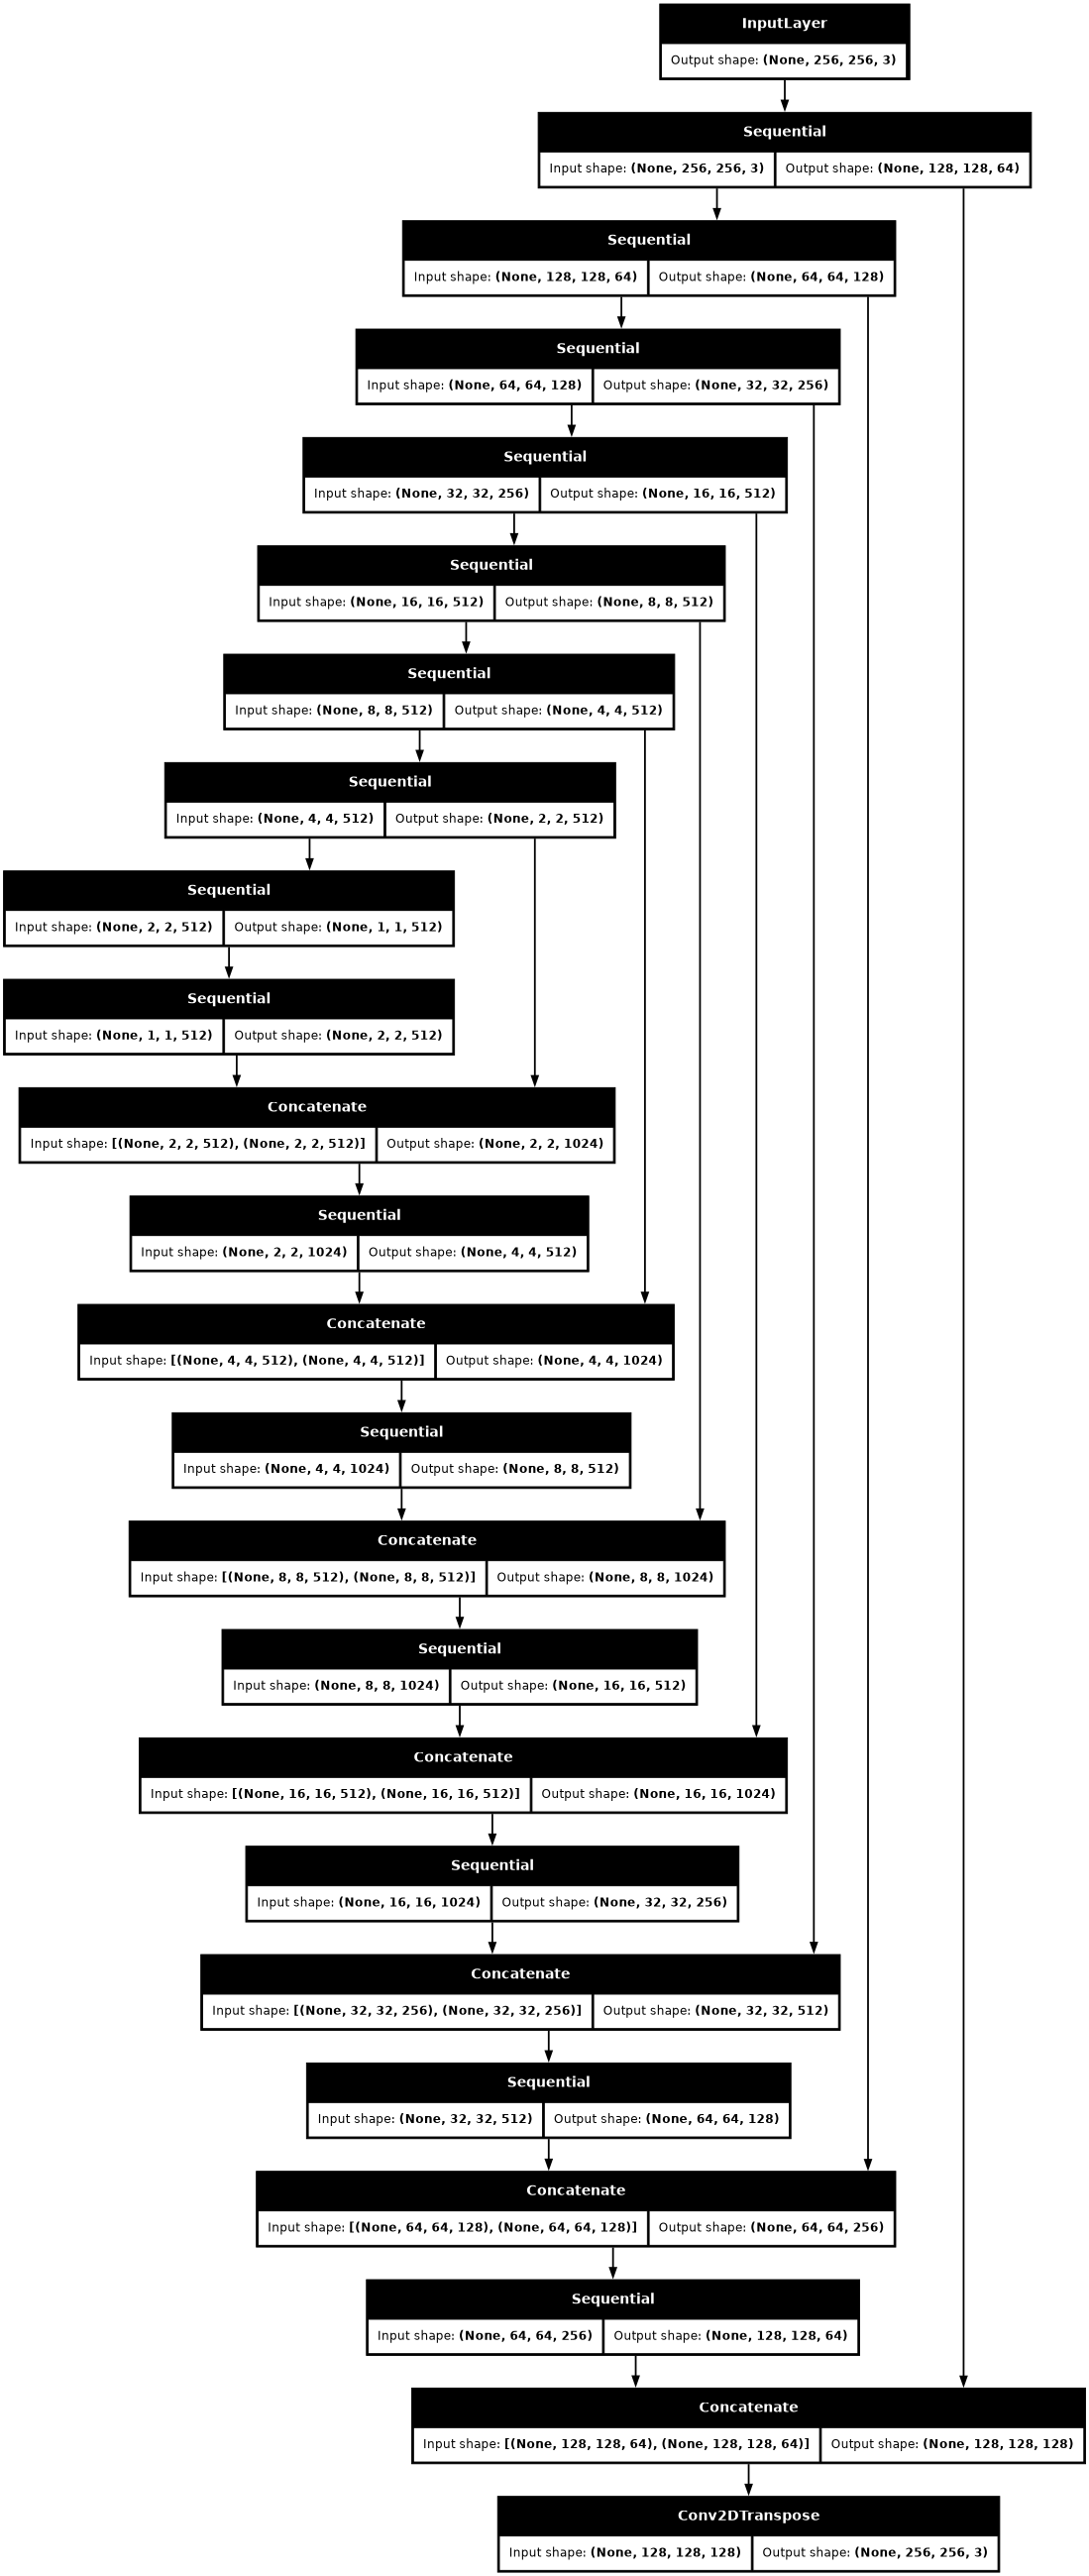

In [54]:
# Create a generator
generator = Generator()

# Vislualize the generator architecture
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# **Discriminator**

The discriminator classifies the image as real or generated.

In [55]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

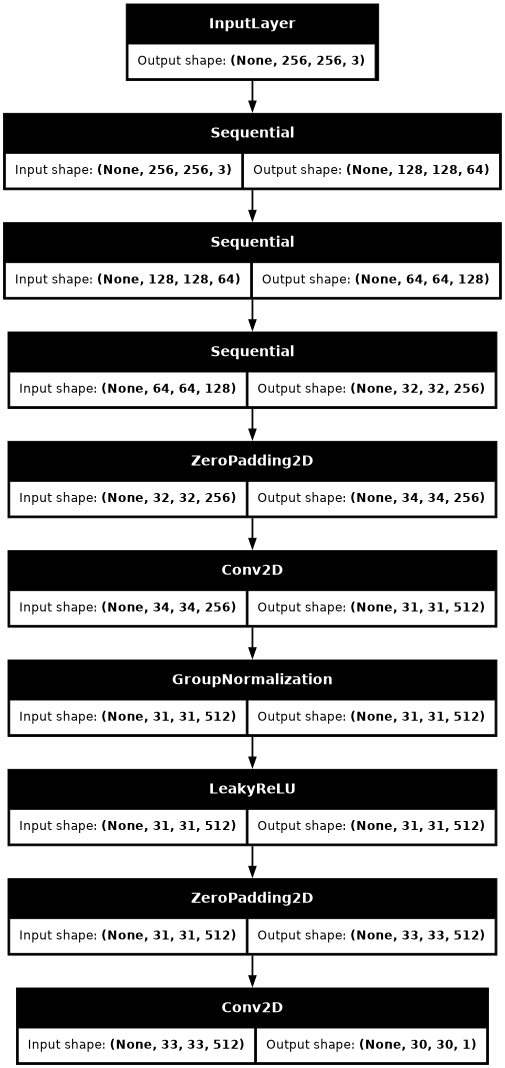

In [56]:
# Create a discriminator
discriminator = Discriminator()

# Visualize the discriminator architecture
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [57]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

# **CycleGAN model**

In [58]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def call(self, inputs):
        print(f"Inputs shape: {inputs.shape}")
        
        real_monet, real_photo = inputs
        # Generate fake Monet and fake photos
        fake_monet = self.m_gen(real_photo, training=True)
        fake_photo = self.p_gen(real_monet, training=True)
        # Cycle back
        cycled_monet = self.m_gen(fake_photo, training=True)
        cycled_photo = self.p_gen(fake_monet, training=True)
        # Identity mapping
        same_monet = self.m_gen(real_monet, training=True)
        same_photo = self.p_gen(real_photo, training=True)
        return fake_monet, fake_photo, cycled_monet, cycled_photo, same_monet, same_photo

#     @tf.function
#     def call(self, inputs):
#         real_monet, real_photo = inputs
#         # Generate fake Monet and fake photos
#         fake_monet = self.m_gen(real_photo, training=True)
#         fake_photo = self.p_gen(real_monet, training=True)
#         return fake_monet, fake_photo        

#     @tf.function
#     def call(self, inputs):
#         real_monet, real_photo = inputs

#         # Generate fake Monet and fake photos
#         fake_monet = self.m_gen(real_photo, training=True)
#         fake_photo = self.p_gen(real_monet, training=True)

#         # Cycle back
#         cycled_monet = self.m_gen(fake_photo, training=True)
#         cycled_photo = self.p_gen(fake_monet, training=True)

#         # Identity mapping
#         same_monet = self.m_gen(real_monet, training=True)
#         same_photo = self.p_gen(real_photo, training=True)

#         return fake_monet, fake_photo, cycled_monet, cycled_photo, same_monet, same_photo

#     @tf.function
#     def call(self, inputs):
#         real_monet, real_photo = inputs
#         # Generate fake Monet and fake photos
#         fake_monet = self.m_gen(real_photo, training=True)
#         fake_photo = self.p_gen(real_monet, training=True)
#         return fake_monet, fake_photo
    
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# **Loss functions**
Loss functions for the generator, discriminator, cycle consistency, and identity.

In [59]:
# Generator loss function
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [60]:
# Discriminator loss function
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [61]:
# Cycle consistency loss function
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [62]:
# Identity loss function
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# **Train the model**

## **Optimizers**

In [63]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## **Model instantiation**

In [64]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

## **Early stopping**

In [65]:
class CombinedLossEarlyStopping(Callback):
    def __init__(self, patience=5, restore_best_weights=True, weight_gen=1.0, weight_cycle=1.0):
        super(CombinedLossEarlyStopping, self).__init__()
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.weight_gen = weight_gen
        self.weight_cycle = weight_cycle
        self.best_weights = None
        self.best_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        # Calculate the combined loss
        combined_loss = (self.weight_gen * logs['monet_gen_loss'] + 
                         self.weight_gen * logs['photo_gen_loss'] +
                         self.weight_cycle * logs['cycle_loss'])

        # If the combined loss has improved, reset the wait counter
        if combined_loss < self.best_loss:
            self.best_loss = combined_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            # If the combined loss has not improved, increase the wait counter
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    self.model.set_weights(self.best_weights)

# Instantiate the callback
combined_loss_early_stopping = CombinedLossEarlyStopping(
    patience = 5,
    restore_best_weights = True,
    weight_gen = 1.0,  # Adjust the weights according to the importance you want to give to each loss
    weight_cycle = 1.0
)

## **Train the model**

In [78]:
%%time

# Original version
# cycle_gan_model.fit(
#     tf.data.Dataset.zip((train_monet_ds, train_photo_ds)),
#     epochs = 3
# )

# # Train the model with the custom callback for early stopping
# cycle_gan_model.fit(
#     tf.data.Dataset.zip((train_monet_ds, train_photo_ds)),
#     validation_data = tf.data.Dataset.zip((val_monet_ds, val_photo_ds)),
#     epochs = 50,  # Set a higher number to allow early stopping to kick in
#     steps_per_epoch = train_size_monet,
#     callbacks = [combined_loss_early_stopping]
# )

# Unbatch before zipping
# train_monet_ds = train_monet_ds.unbatch()
# train_photo_ds = train_photo_ds.unbatch()

# Zip datasets
train_dataset = tf.data.Dataset.zip((train_monet_ds, train_photo_ds))
val_dataset = tf.data.Dataset.zip((val_monet_ds, val_photo_ds))

# Batch
train_monet_ds = train_monet_ds.batch(1).repeat()
val_monet_ds = val_monet_ds.batch(1).repeat()

train_photo_ds = train_photo_ds.batch(1).repeat()
val_photo_ds = val_photo_ds.batch(1).repeat()

# Verify the structure of the zipped dataset
for item in train_dataset.take(5):
    print(item)  # This should print a tuple of two elements

print("train_dataset")
for item in train_dataset.take(1):
    print(item)  # This should print a tuple of two elements
    print()

# Train the model with the custom callback for early stopping
cycle_gan_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 50,  # Set a higher number to allow early stopping to kick in
    steps_per_epoch = train_size_monet,
    callbacks = [combined_loss_early_stopping]
)

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.02745104, 0.13725495, 0.20784318], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.        , -0.94509804, -0.9372549 ], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.02745104, 0.18431377, 0.254902  ], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.9607843, -0.8980392, -0.8745098], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.0745098 ,  0.13725495,  0.22352946], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.9137255 , -0.8745098 , -0.84313726], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.08235294,  0.12156868,  0.23921573], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.9764706 , -0.94509804, -0.8745098 ], dtype=float32)>)
(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.0196079 , 0.20000005, 0.3411765 ], dtype=float32)>, <tf.Tensor: shape=(3,), dt

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input [-0.79607844 -0.40392154 -0.11372548]. Expected shape (None, 256, 256, 3), but input has incompatible shape (3,)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(3,), dtype=float32)
  • training=True
  • mask=None

In [67]:
train_dataset

<_ZipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

## **Use our trained model to generate Monet-like images**

In [68]:
!mkdir /kaggle/working/images

mkdir: cannot create directory '/kaggle/working/images': File exists


In [69]:
%%time

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("/kaggle/working/images/" + str(i) + ".jpg")
    i += 1

ValueError: Input 0 of layer "functional_95" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(256, 256, 3)

In [70]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [71]:
# # Generate a unique filename with a timestamp
# # timestamp = datetime.now().strftime('%Y-%m-%d_%H%M')
# # filename = f'dtsa-5511-m5-submission_{timestamp}.csv'
# filename = '/kaggle/working/images.zip'

# # Generate a download link.
# FileLink(rf'{filename}')